# Reducción de la dimensionalidad

Tal como se ha comentado en las clases teóricas, uno de los puntos más importantes a la hora de afrontar probelmas, especialmente cuando tienen una alta dimensionalidad, es la reducción de dichas dimensiones con algunas de las técnicas enunciadas en clase. 

## Instalación
El primer paso es comprobar que todos los paquetes necesarios están disponibles

In [64]:
using Pkg
Pkg.add("ScikitLearn")
Pkg.add("RDatasets")
Pkg.add("DataFrames")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


## Importación de dependencias
Este no pretende ser un ejemplo exhaustivo de como realizar cualquier reducción si no un mero ejemplo. Por ello, está apoyado por el uso de la librería ScikitLearn que es un wrapper de la versión en Python de la misma. Es posible también usar otros frameworks com MLJ pero la integración de algunas de las técnicas como LLE o Isomap no está soportadas y deberían de implementarse.
Por todo lo anterior a continuación importaremos las librerías y modulos que nos hacen falta

In [70]:
using ScikitLearn
using ScikitLearn.Pipelines: Pipeline
using ScikitLearn.CrossValidation: train_test_split
@sk_import feature_selection: (SelectKBest, f_classif)
@sk_import preprocessing: (MinMaxScaler, LabelEncoder)
@sk_import decomposition: (PCA, FastICA)
@sk_import discriminant_analysis: LinearDiscriminantAnalysis
@sk_import manifold: (Isomap, LocallyLinearEmbedding)
@sk_import linear_model: LogisticRegression

using RDatasets
using DataFrames

También a modo de ejemplo vamos a importar el problema de las flores Iris, así como transformarlo para usarlo con un conjunto de entrenamiento y otro de test

In [71]:
# Cargar el dataset Iris
iris = dataset("datasets", "iris")
X = Matrix(iris[:, 1:4])
y = string.(iris[:, 5])  # Convertir la variable objetivo en un vector de Strings

# Convertir la variable objetivo en codificación numérica
y = fit_transform!(LabelEncoder(), y)

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42);


### Definir las técnicas de reducción que se van a emplear
En este caso nos centraremso en transformaciones que están incluidas en ScikitLearn si bien se podrían usar otras. En concreto se van a emplear PCA, ICA, LDA, ISomap y LLE. Recuerde que si bien en este caso IsoMap y LLE se emplean con la clasificación su función es la de la representación dado que son transformaciones no lineales sin vuelta.

In [72]:
# Definimos un diccionario con las técnicas de reducción de dimensionalidad
techniques = Dict(
    "Filtrado"=> SelectKBest(score_func=f_classif, k=2),
    "PCA" => PCA(n_components=2),
    "ICA" => FastICA(n_components=2),
    "LDA" => LinearDiscriminantAnalysis(n_components=2),
    "Isomap" => Isomap(n_components=2),
    "LLE" => LocallyLinearEmbedding(n_components=2)
)

Dict{String, PyCall.PyObject} with 6 entries:
  "ICA"      => PyObject FastICA(n_components=2)
  "Isomap"   => PyObject Isomap()
  "LLE"      => PyObject LocallyLinearEmbedding()
  "PCA"      => PyObject PCA(n_components=2)
  "Filtrado" => PyObject SelectKBest(k=2)
  "LDA"      => PyObject LinearDiscriminantAnalysis(n_components=2)

Una vez definido un diccionario con dichas técnicas, el siguiente paso es usarlo para definir diferentes *Pipelines* y comprobar las diferencias entre ellos.

In [73]:
# Almacenamiento de resultados
results = DataFrame(Technique = String[], Accuracy = Float64[])

# Iterar sobre las técnicas
for (name, reducer) in techniques
    # Crear el pipeline: estandarización + reducción dimensional + regresión logística
    model = Pipeline([
        ("scaler", MinMaxScaler()),   # Estandarización de los datos
        ("reducer", reducer),           # Reducción de dimensionalidad
        ("classifier", LogisticRegression())  # Modelo de clasificación
    ])
    
    # Entrenar el modelo
    fit!(model, X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = predict(model, X_test)
    
    # Calcular la precisión del modelo
    accuracy = sum(y_pred .== y_test) / length(y_test)
    
    # Almacenar los resultados
    push!(results, (name, accuracy))
    
    # Mostrar resultados parciales
    println("Técnica: $name, Precisión: $accuracy")
end

# Mostrar resultados finales
println(results)

Técnica: ICA, Precisión: 0.9777777777777777
Técnica: Isomap, Precisión: 0.9555555555555556


/home/quique/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/quique/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Técnica: LLE, Precisión: 0.7333333333333333
Técnica: PCA, Precisión: 0.8666666666666667
Técnica: Filtrado, Precisión: 1.0
Técnica: LDA, Precisión: 1.0
6×2 DataFrame
 Row │ Technique  Accuracy 
     │ String     Float64  
─────┼─────────────────────
   1 │ ICA        0.977778
   2 │ Isomap     0.955556
   3 │ LLE        0.733333
   4 │ PCA        0.866667
   5 │ Filtrado   1.0
   6 │ LDA        1.0


# Representación

Por último vamos a representar el espacio de entrada de todos los conjuntos con su correspondiente transformación. Para este punto haremos uso de una función auxiliar y el paquete `Plots`

/home/quique/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/quique/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


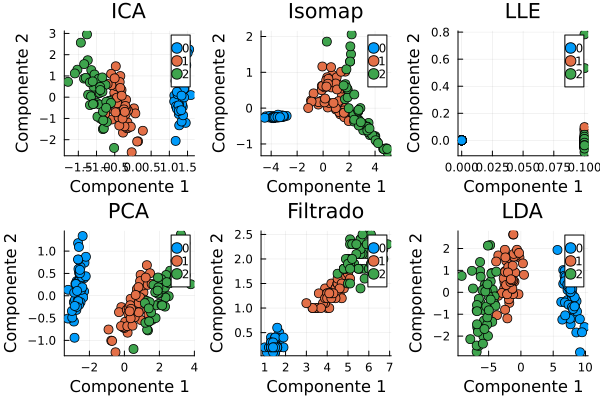

In [78]:
# Generar scatterplots de las transformaciones
function plot_transformed_data(name::String, reducer, X, y)
    # Aplicar la reducción de dimensionalidad
    X_reduced = fit_transform!(reducer, X, y)
    
    # Crear el scatterplot
    p = scatter(X_reduced[:, 1], X_reduced[:, 2], group=y, legend=:topright, title=name,
                xlabel="Componente 1", ylabel="Componente 2", markersize=5)
    return p
end

# Crear los scatterplots en una cuadrícula
plot_layout = @layout [a b c; d e f]
plots = [plot_transformed_data(name, reducer, X, y) for (name, reducer) in techniques]

# Mostrar todos los scatterplots en una cuadrícula
plot(plots..., layout=plot_layout)